# Probabilistic-Matrix-Factorization

- [Repositorio](https://github.com/fuhailin/Probabilistic-Matrix-Factorization/tree/master)

- [Paper](https://proceedings.neurips.cc/paper_files/paper/2007/hash/d7322ed717dedf1eb4e6e52a37ea7bcd-Abstract.html)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import *
import random
from sklearn.model_selection import train_test_split
import nbformat as nbf
import pathlib, os

## 1. Cargar BD 'u.data'

    Unicamente devuelve las columnas user_id, item_id, rating

In [10]:
u_data = "data/u.data"

def load_rating_data(u_data_path: pathlib.Path) -> np.ndarray:
    data = np.loadtxt(u_data_path, dtype=np.int64)
    # userId, itemId empiezan en 1 -> pasamos a base-0
    data[:, 0] -= 1
    data[:, 1] -= 1
    # Solamente queremos quedarnos con las columnas: user, item, rating (ignoramos timestamp)
    return data[:, :3].astype(np.float64)

ratings = load_rating_data(u_data)
n_users = int(ratings[:, 0].max()) + 1
n_items = int(ratings[:, 1].max()) + 1

print(f" {len(ratings)} registros de {n_users} usuarios que han valorado {n_items} películas")

 100000 registros de 943 usuarios que han valorado 1682 películas


## 2. Train /test

    Dividir el dataset en train (80%) y test(20%)

In [11]:
train, test = train_test_split(ratings, test_size=0.2, random_state=42)

print(f"De los {len(ratings)} datos totales, "
      f"{len(train)} ({len(train)/len(ratings)*100:.0f}%) son para train "
      f"y {len(test)} ({len(test)/len(ratings)*100:.0f}%) para test.")

De los 100000 datos totales, 80000 (80%) son para train y 20000 (20%) para test.


## 3. Definir PMF

    (La Clase PMF es igual que la del repositorio)

In [43]:

class PMF(object):
    def __init__(self, num_feat=10, epsilon=1, _lambda=0.1, momentum=0.8, maxepoch=20, num_batches=10, batch_size=1000, lr_decay=1.0, decay_step=5):
        self.num_feat = num_feat      # Number of latent features
        self.epsilon = epsilon        # Learning rate
        self._lambda = _lambda        # L2 regularization
        self.momentum = momentum      # Momentum of the gradient
        self.maxepoch = maxepoch      # Number of epoch before stop
        self.num_batches = num_batches # Number of batches in each epoch
        self.batch_size = batch_size  # Number of training samples used in each batch
        
        # --- NUEVOS PARÁMETROS PARA EL SCHEDULER ---
        self.lr_decay = lr_decay      # Factor de decaimiento del learning rate (1.0 = sin decaimiento)
        self.decay_step = decay_step  # Cada cuántas epochs se aplica el decaimiento

        # Matrices latentes para items y usuarios (se inicializan después)
        self.w_Item = None
        self.w_User = None

        # Listas para guardar la evolución de los errores
        self.rmse_train = []
        self.rmse_test = []

    def fit(self, train_vec, test_vec):
        # Calcula el promedio global de las valoraciones
        self.mean_inv = np.mean(train_vec[:, 2])

        pairs_train = train_vec.shape[0]
        pairs_test = test_vec.shape[0]

        # Calcula número total de usuarios e items (máx id + 1)
        num_user = int(max(np.amax(train_vec[:, 0]), np.amax(test_vec[:, 0]))) + 1
        num_item = int(max(np.amax(train_vec[:, 1]), np.amax(test_vec[:, 1]))) + 1

        incremental = False
        if ((not incremental) or (self.w_Item is None)):
            # Inicialización de matrices y momentum
            self.epoch = 0
            self.w_Item = 0.1 * np.random.randn(num_item, self.num_feat)
            self.w_User = 0.1 * np.random.randn(num_user, self.num_feat)
            self.w_Item_inc = np.zeros((num_item, self.num_feat))
            self.w_User_inc = np.zeros((num_user, self.num_feat))

        # --- Bucle de entrenamiento por épocas ---
        while self.epoch < self.maxepoch:
            self.epoch += 1

            # --- INICIO: LÓGICA DEL SCHEDULER DE LEARNING RATE ---
            # Se aplica el decaimiento si la epoch actual es múltiplo del `decay_step`
            if self.epoch > 0 and self.epoch % self.decay_step == 0:
                self.epsilon *= self.lr_decay
                print(f"--- Epoch {self.epoch}: Learning rate reducido a {self.epsilon:.6f} ---")
            # --- FIN: LÓGICA DEL SCHEDULER ---

            # Mezcla los datos de entrenamiento
            shuffled_order = np.arange(train_vec.shape[0])
            np.random.shuffle(shuffled_order)

            # --- Actualización por batches (SGD) ---
            for batch in range(self.num_batches):
                test = np.arange(self.batch_size * batch, self.batch_size * (batch + 1))
                batch_idx = np.mod(test, shuffled_order.shape[0])

                batch_UserID = np.array(train_vec[shuffled_order[batch_idx], 0], dtype='int32')
                batch_ItemID = np.array(train_vec[shuffled_order[batch_idx], 1], dtype='int32')

                # Calcula la predicción y el error
                pred_out = np.sum(np.multiply(self.w_User[batch_UserID, :], self.w_Item[batch_ItemID, :]), axis=1)
                rawErr = pred_out - train_vec[shuffled_order[batch_idx], 2] + self.mean_inv

                # Calcula los gradientes
                Ix_User = 2 * np.multiply(rawErr[:, np.newaxis], self.w_Item[batch_ItemID, :]) + self._lambda * self.w_User[batch_UserID, :]
                Ix_Item = 2 * np.multiply(rawErr[:, np.newaxis], self.w_User[batch_UserID, :]) + self._lambda * (self.w_Item[batch_ItemID, :])

                dw_Item = np.zeros((num_item, self.num_feat))
                dw_User = np.zeros((num_user, self.num_feat))

                # Agrega los gradientes
                for i in range(self.batch_size):
                    dw_Item[batch_ItemID[i], :] += Ix_Item[i, :]
                    dw_User[batch_UserID[i], :] += Ix_User[i, :]

                # Actualiza los pesos con momentum
                self.w_Item_inc = self.momentum * self.w_Item_inc + self.epsilon * dw_Item / self.batch_size
                self.w_User_inc = self.momentum * self.w_User_inc + self.epsilon * dw_User / self.batch_size
                self.w_Item = self.w_Item - self.w_Item_inc
                self.w_User = self.w_User - self.w_User_inc

                # Al final de la epoch, calcula y guarda los errores
                if batch == self.num_batches - 1:
                    # Error en Train
                    pred_out_train = np.sum(np.multiply(self.w_User[np.array(train_vec[:, 0], dtype='int32'), :], self.w_Item[np.array(train_vec[:, 1], dtype='int32'), :]), axis=1)
                    rawErr_train = pred_out_train - train_vec[:, 2] + self.mean_inv
                    obj_train = np.linalg.norm(rawErr_train) ** 2 + 0.5 * self._lambda * (np.linalg.norm(self.w_User) ** 2 + np.linalg.norm(self.w_Item) ** 2)
                    self.rmse_train.append(np.sqrt(obj_train / pairs_train))

                    # Error en Test
                    pred_out_test = np.sum(np.multiply(self.w_User[np.array(test_vec[:, 0], dtype='int32'), :], self.w_Item[np.array(test_vec[:, 1], dtype='int32'), :]), axis=1)
                    rawErr_test = pred_out_test - test_vec[:, 2] + self.mean_inv
                    self.rmse_test.append(np.linalg.norm(rawErr_test) / np.sqrt(pairs_test))

                    print('Epoch: %d, Training RMSE: %.4f, Test RMSE %.4f' % (self.epoch, self.rmse_train[-1], self.rmse_test[-1]))

    def predict(self, invID):
        return np.dot(self.w_Item, self.w_User[int(invID), :]) + self.mean_inv

    def set_params(self, parameters):
        if isinstance(parameters, dict):
            self.num_feat = parameters.get("num_feat", 10)
            self.epsilon = parameters.get("epsilon", 1)
            self._lambda = parameters.get("_lambda", 0.1)
            self.momentum = parameters.get("momentum", 0.8)
            self.maxepoch = parameters.get("maxepoch", 20)
            self.num_batches = parameters.get("num_batches", 10)
            self.batch_size = parameters.get("batch_size", 1000)
            
            # --- AÑADIDO PARA EL SCHEDULER ---
            self.lr_decay = parameters.get("lr_decay", 1.0)
            self.decay_step = parameters.get("decay_step", 5)

    def topK(self, test_vec, k=10):
        inv_lst = np.unique(test_vec[:, 0])
        pred = {}
        for inv in inv_lst:
            if pred.get(inv, None) is None:
                pred[inv] = np.argsort(self.predict(inv))[-k:]

        intersection_cnt = {}
        for i in range(test_vec.shape[0]):
            if test_vec[i, 1] in pred[test_vec[i, 0]]:
                intersection_cnt[test_vec[i, 0]] = intersection_cnt.get(test_vec[i, 0], 0) + 1
        invPairs_cnt = np.bincount(np.array(test_vec[:, 0], dtype='int32'))

        precision_acc = 0.0
        recall_acc = 0.0
        for inv in inv_lst:
            precision_acc += intersection_cnt.get(inv, 0) / float(k)
            recall_acc += intersection_cnt.get(inv, 0) / float(invPairs_cnt[int(inv)])

        return precision_acc / len(inv_lst), recall_acc / len(inv_lst)

## 4. Definir modelo PMF



In [44]:
pmf = PMF()
pmf.set_params({
    "num_feat": 10,
    "epsilon": 1.0, # FACTOR DE APRENDIZAJE
    "_lambda": 0.1, 
    "momentum": 0.8,
    "maxepoch": 100,     # <--
    "num_batches": 100,
    "batch_size": 1000,
})

### Entrenar modelo

In [45]:
pmf.fit(train, test)

Epoch: 1, Training RMSE: 1.1241, Test RMSE 1.1243
Epoch: 2, Training RMSE: 1.1215, Test RMSE 1.1235
Epoch: 3, Training RMSE: 1.1164, Test RMSE 1.1207
Epoch: 4, Training RMSE: 1.1027, Test RMSE 1.1104
--- Epoch 5: Learning rate reducido a 1.000000 ---
Epoch: 5, Training RMSE: 1.0709, Test RMSE 1.0847
Epoch: 6, Training RMSE: 1.0276, Test RMSE 1.0512
Epoch: 7, Training RMSE: 0.9867, Test RMSE 1.0218
Epoch: 8, Training RMSE: 0.9507, Test RMSE 0.9974
Epoch: 9, Training RMSE: 0.9225, Test RMSE 0.9790
--- Epoch 10: Learning rate reducido a 1.000000 ---
Epoch: 10, Training RMSE: 0.9015, Test RMSE 0.9669
Epoch: 11, Training RMSE: 0.8848, Test RMSE 0.9581
Epoch: 12, Training RMSE: 0.8706, Test RMSE 0.9517
Epoch: 13, Training RMSE: 0.8579, Test RMSE 0.9473
Epoch: 14, Training RMSE: 0.8465, Test RMSE 0.9434
--- Epoch 15: Learning rate reducido a 1.000000 ---
Epoch: 15, Training RMSE: 0.8363, Test RMSE 0.9408
Epoch: 16, Training RMSE: 0.8268, Test RMSE 0.9384
Epoch: 17, Training RMSE: 0.8180, Test

### Visualizar 


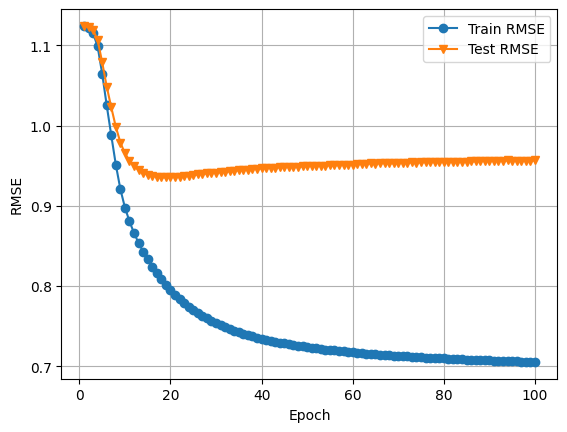

In [8]:
plt.plot(range(1, len(pmf.rmse_train)+1), pmf.rmse_train, marker='o', label='Train RMSE')
plt.plot(range(1, len(pmf.rmse_test)+1), pmf.rmse_test, marker='v', label='Test RMSE')
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.legend()
plt.grid(True)
plt.show()